## 라이브러리 설치

In [ ]:
!pip install librosa matplotlib seaborn tensorflow tqdm xgboost catboost scikit-learn keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 21.6 MB/s eta 0:00:00


## 구글드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 데이터 불러오기

In [ ]:
!cp /content/drive/MyDrive/DATASET-balanced.csv /content/DATASET-balanced.csv

## 라이브러리 불러오기

In [ ]:
import pandas as pd
import numpy as np
import librosa
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    Conv1D,
    LSTM,
    Bidirectional,
    Dropout,
    BatchNormalization,
    Dense,
    MaxPooling1D,
    concatenate,
    GlobalAveragePooling1D,
    Flatten,
)

from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import save_model, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, confusion_matrix, roc_curve

import seaborn as sns
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
np.random.seed(42)
tf.random.set_seed(42)


# Exploratory Data Analysis (EDA)

In [ ]:
data_path = "/content/DATASET-balanced.csv"
df = pd.read_csv(data_path)
df.head()

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,LABEL
0,0.338055,0.027948,2842.948867,4322.916759,6570.586186,0.041050,-462.169586,90.311272,19.073769,24.046888,...,-6.686564,0.902086,-7.251551,-1.198342,4.747403,-4.986279,0.953935,-5.013138,-6.779060,FAKE
1,0.443766,0.037838,2336.129597,3445.777044,3764.949874,0.047730,-409.413422,120.348808,-7.161531,5.114784,...,-2.131157,-6.876417,-1.359395,0.326401,-5.420016,-2.109968,-1.757634,-9.537907,-8.494421,FAKE
2,0.302528,0.056578,2692.988386,2861.133180,4716.610271,0.080342,-318.996033,120.490273,-24.625771,23.891073,...,-5.853725,-3.724773,-6.627182,-5.117002,-6.072106,-0.994653,-1.617120,-3.922354,-7.033001,FAKE
3,0.319933,0.031504,2241.665382,3503.766175,3798.641521,0.047180,-404.636749,136.320908,2.308172,-3.907071,...,-1.898315,-2.046493,-7.176277,-3.293508,4.209121,0.121835,-5.407063,-3.654926,-3.274857,FAKE
4,0.420055,0.016158,2526.069123,3102.659519,5025.077899,0.051905,-410.497925,152.731400,-18.266771,51.993462,...,-1.952340,0.810868,6.238493,6.555839,7.535542,2.849219,2.616843,-1.793357,-5.060998,FAKE


The dataset contains processed features extracted from audio files.

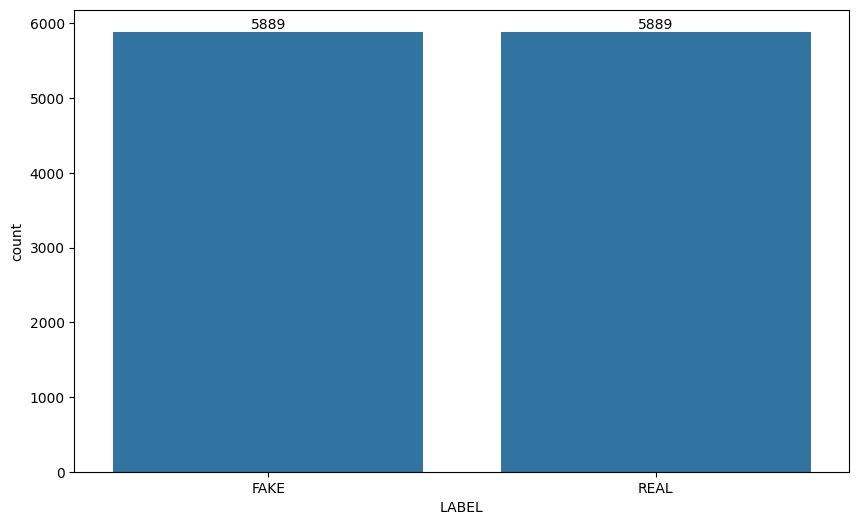

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='LABEL')

for p in plt.gca().patches:
    plt.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.1, int(p.get_height()),
             ha='center', va='bottom')

plt.show()

As we can see, the dataset is perfectly balanced with 5898 Fake and 5898 Real samples

## 라벨 인코딩

In [ ]:
label_encoder = LabelEncoder()
df['LABEL'] = label_encoder.fit_transform(df['LABEL'])

Putting the features and labels into variables X and y.

In [ ]:
y = df['LABEL']
X = df.drop('LABEL', axis = 1)

## 데이터 분포 분석

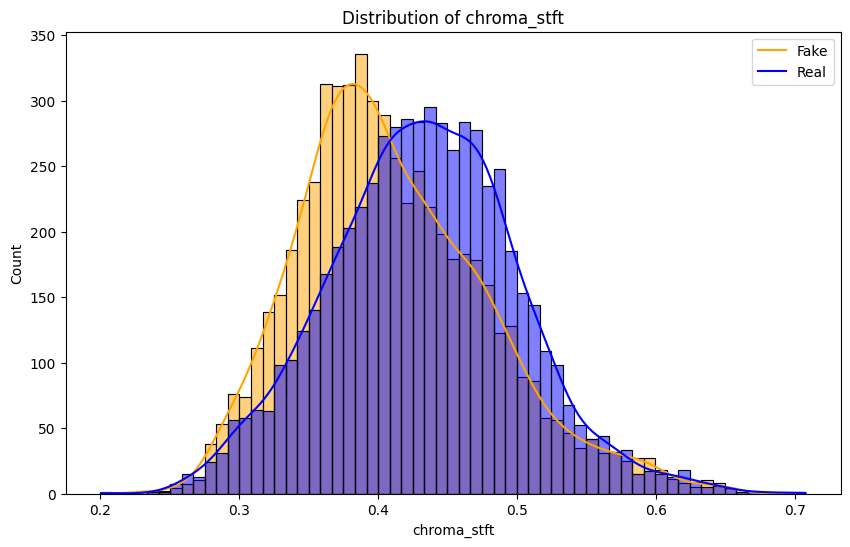

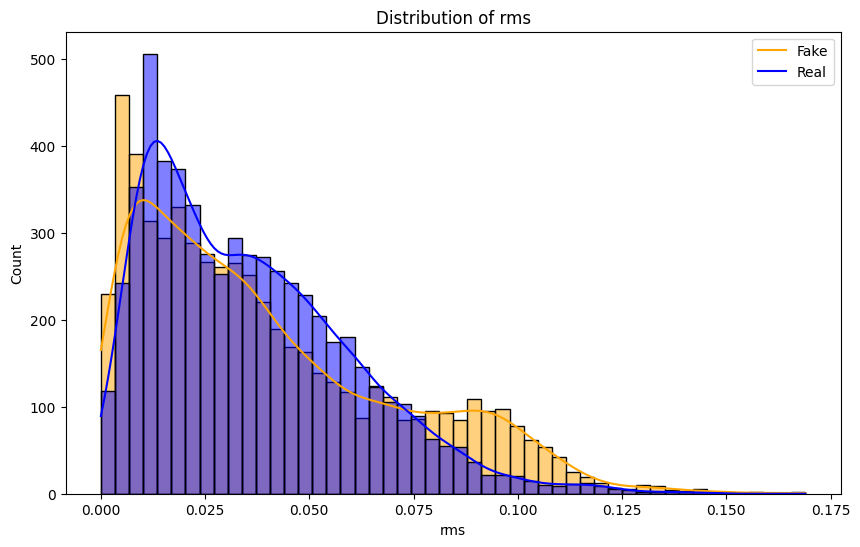

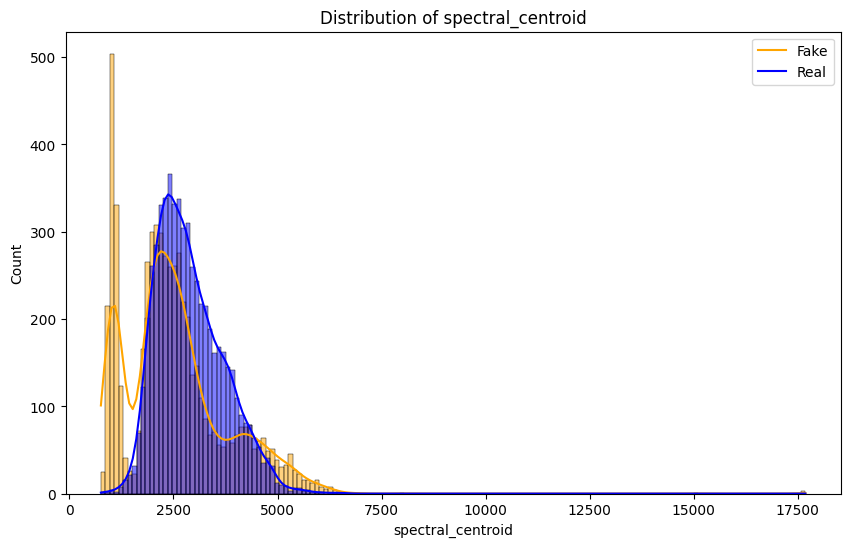

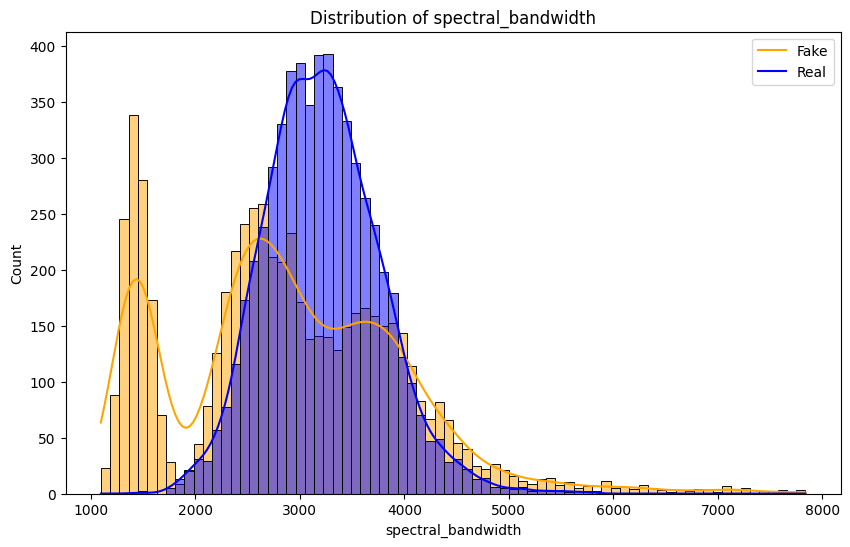

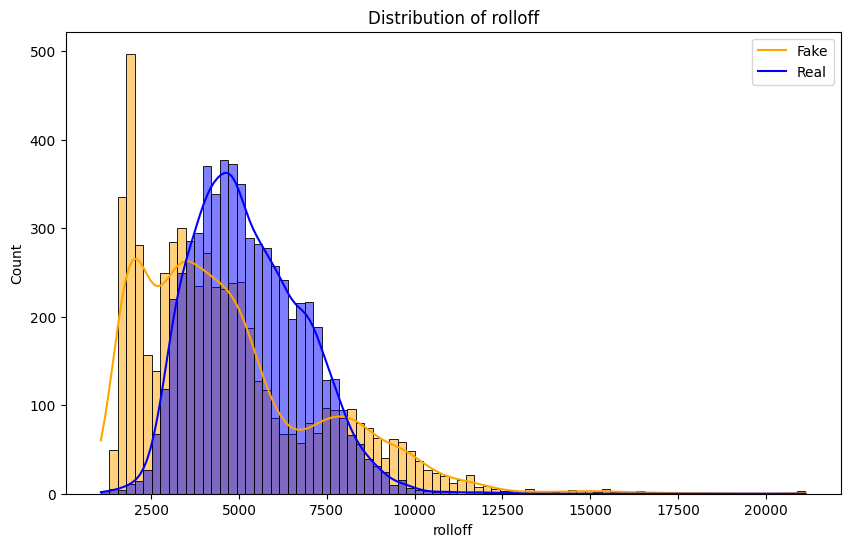

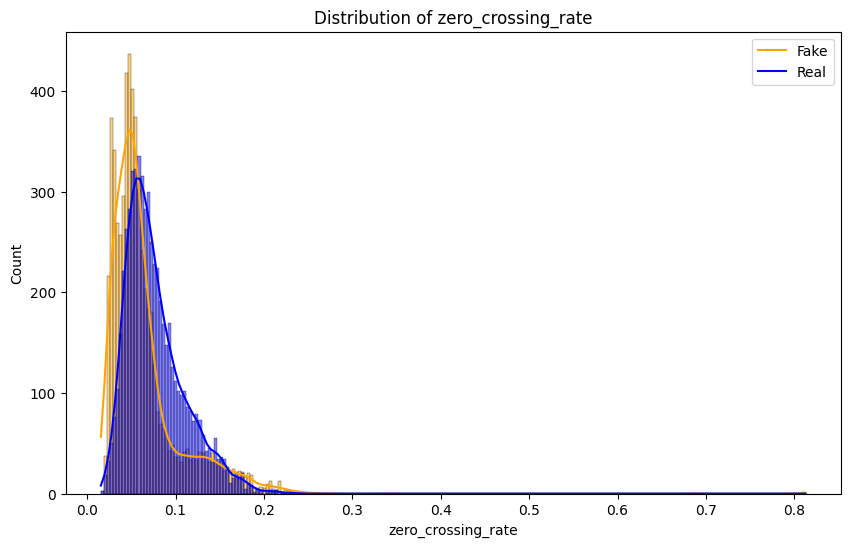

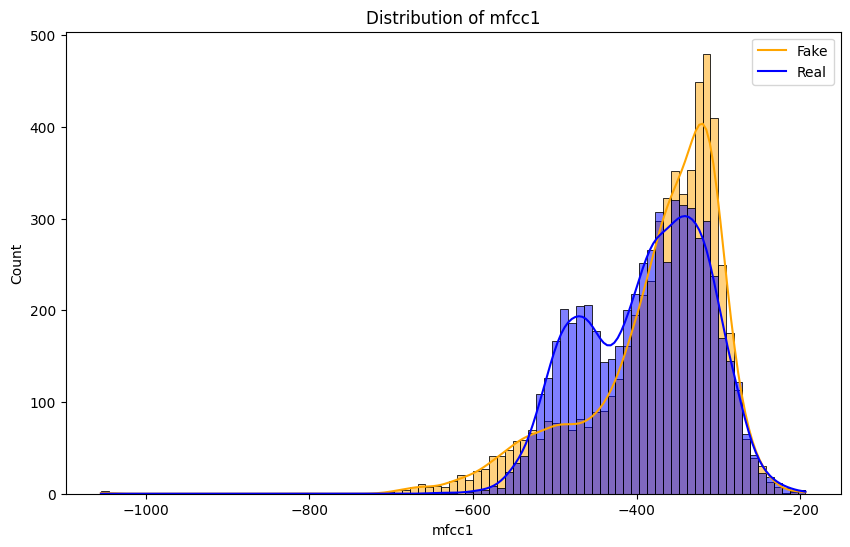

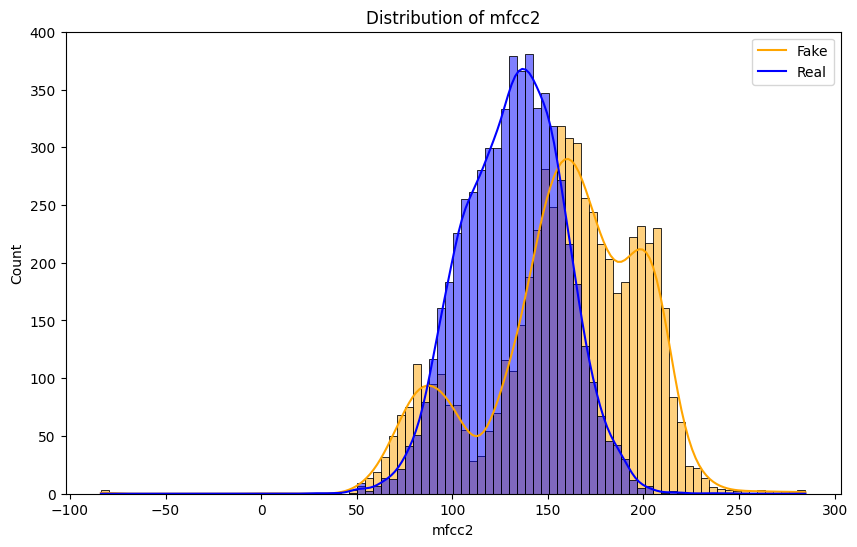

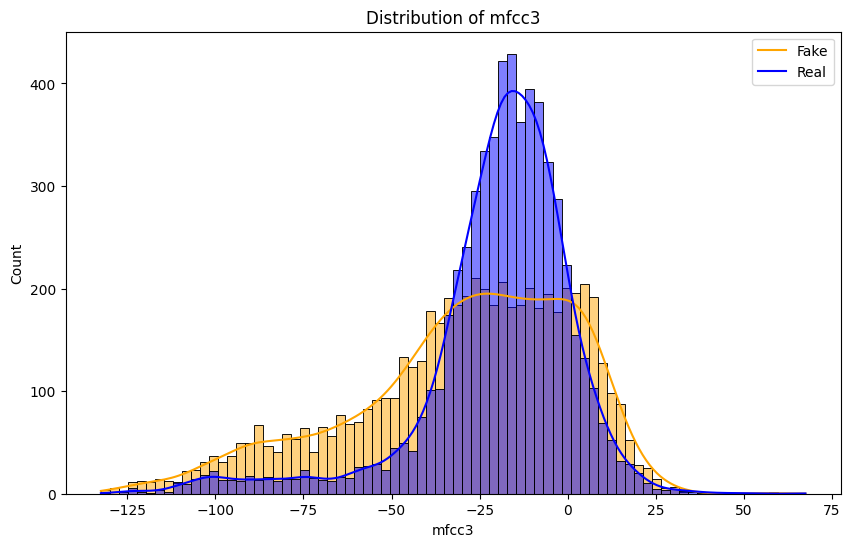

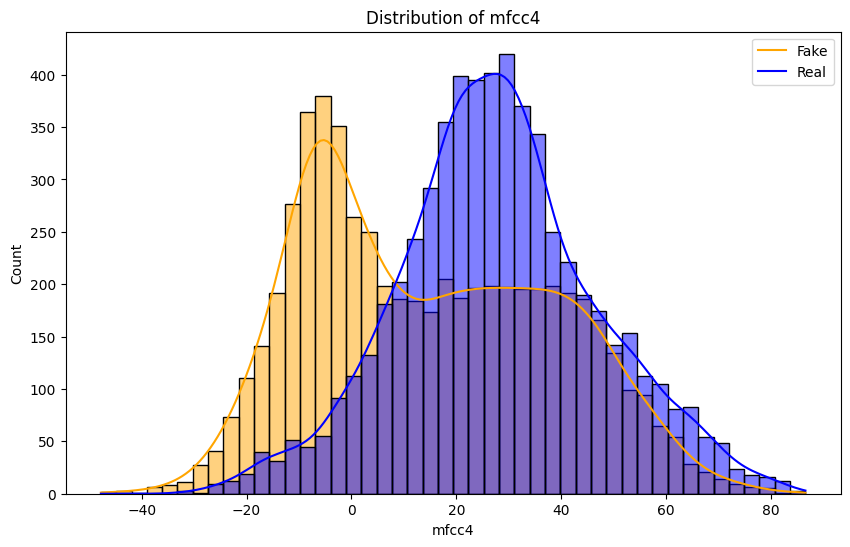

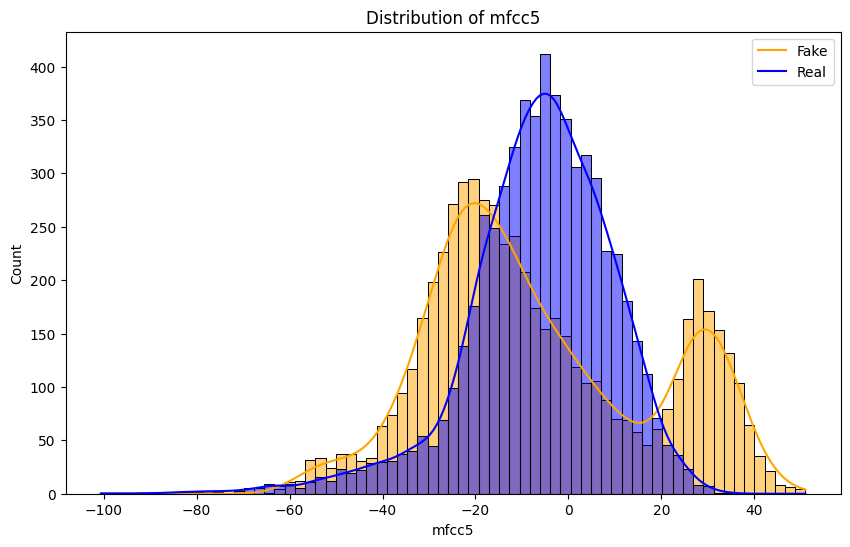

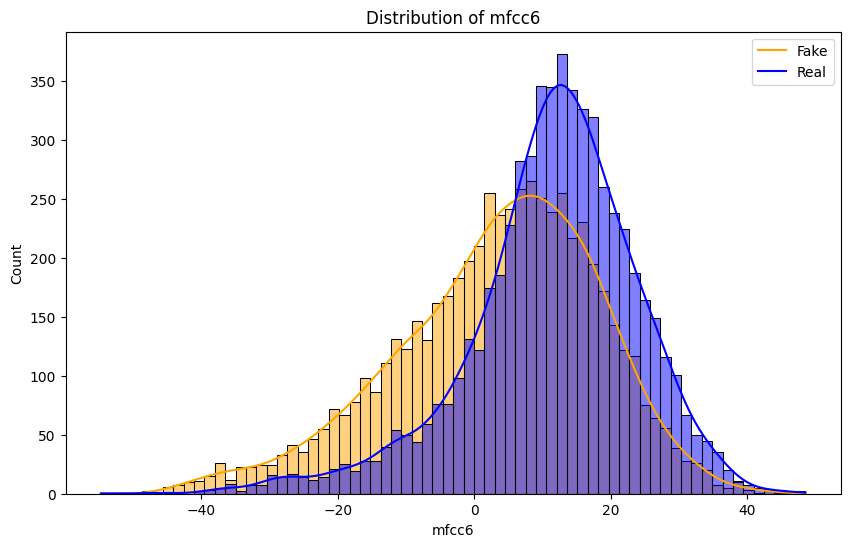

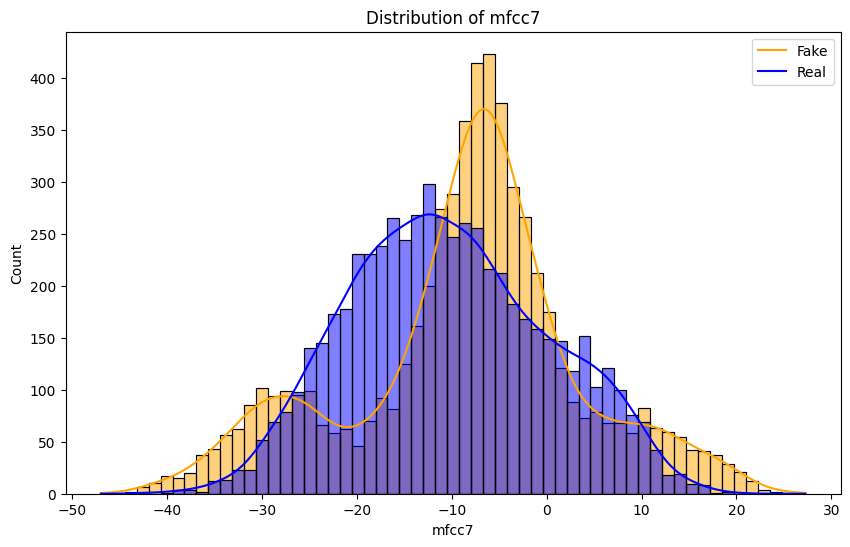

KeyboardInterrupt: 

In [ ]:
for column in X:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=column, hue='LABEL', kde=True, palette=['blue', 'orange'])
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.legend(labels=['Fake', 'Real'])
    plt.show()

## Correlation  Matrix

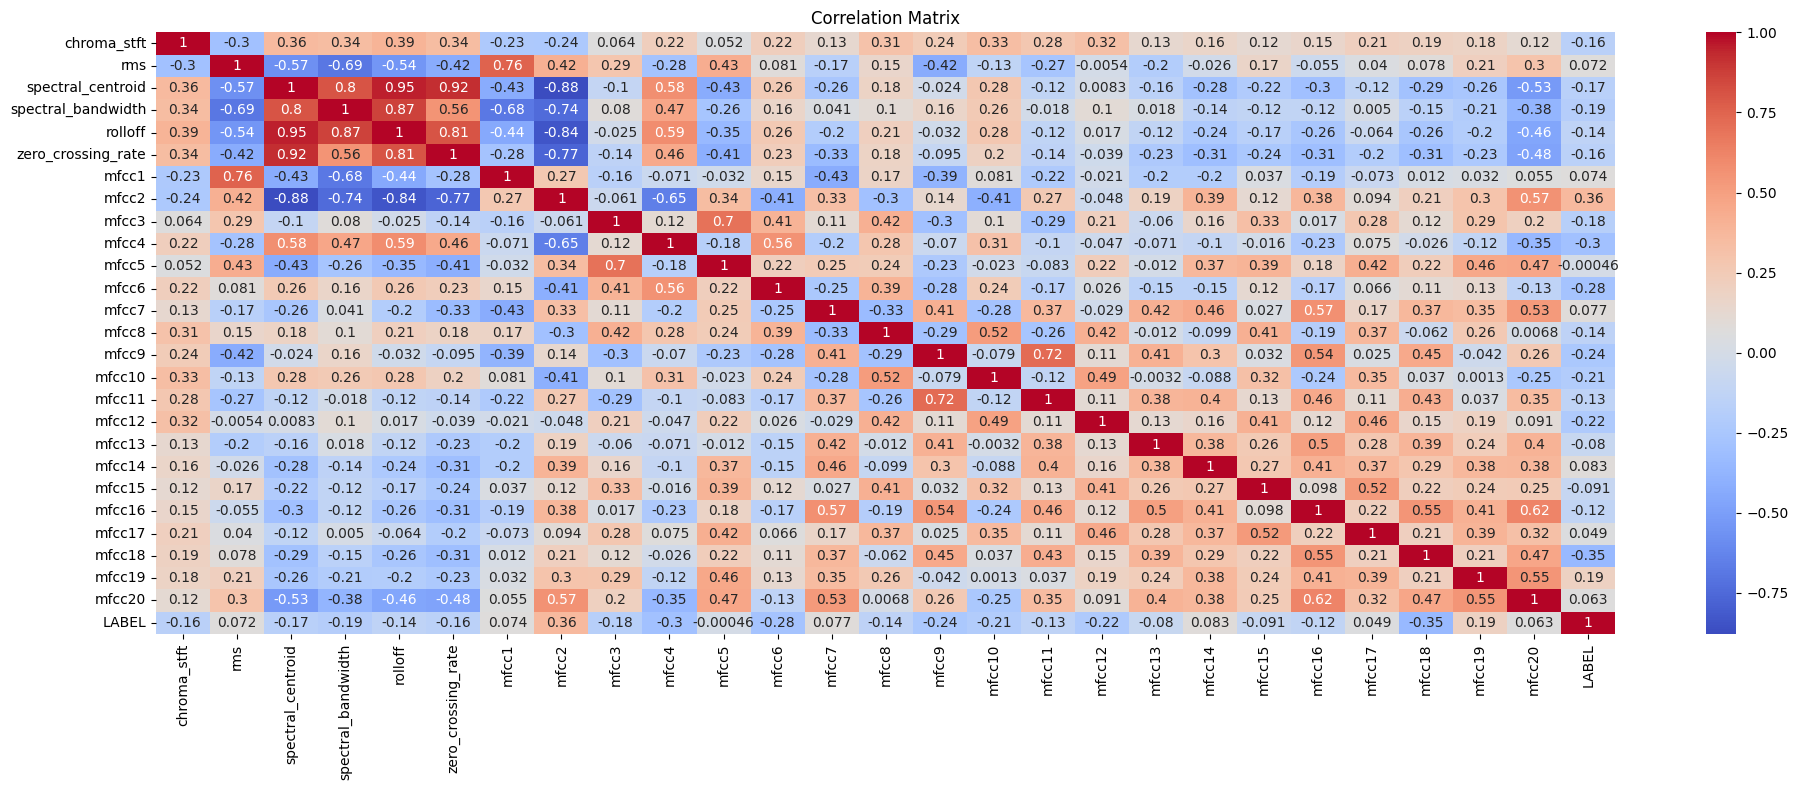

In [ ]:
correlation_matrix = df.corr()
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot = True)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# LSTM

## 데이터 전처리

In [ ]:
def prepare_data(X, window_size = 10):

    data = []

    for i in range(len(X)):
        row = X.iloc[i].values
        row_data = []
        for j in range(len(row) - window_size):
            window = row[j : j + window_size]
            row_data.append(window)
        data.append(row_data)

    return np.array(data)

In [ ]:
X.iloc[:, :] = MinMaxScaler().fit_transform(X)
new_X = prepare_data(X, window_size = 5)

## 데이터 분리(트레이닝, 테스트)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y.values, test_size=0.2, shuffle = True, stratify = y.values, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle = True, stratify = y_train, random_state=42)

## LSTM 모델 설계

In [ ]:
# 모델 초기화
model = Sequential()

input_shape = (X_train.shape[1], X_train.shape[2])
model.add(Input(shape=input_shape))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 21, 256)             │         137,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 21, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 21, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 21, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 21, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 21, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 708,737 (2.70 MB)

 Trainable params: 707,457 (2.70 MB)

 Non-trainable params: 1,280 (5.00 KB)

모델 체크포인트 저장 선언

In [ ]:
callback = [
    ModelCheckpoint(filepath='kaggle_norm_model.keras'),
]

## LSTM 모델 학습

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=60, validation_data = (X_val, y_val), callbacks = callback)

Epoch 1/60
236/236 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.6100 - loss: 0.6737 - val_accuracy: 0.4997 - val_loss: 1.2741
Epoch 2/60
236/236 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7188 - loss: 0.5572 - val_accuracy: 0.4997 - val_loss: 2.7524
Epoch 3/60
236/236 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7595 - loss: 0.5077 - val_accuracy: 0.4997 - val_loss: 3.0098
Epoch 4/60
236/236 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8195 - loss: 0.4027 - val_accuracy: 0.5374 - val_loss: 1.4562
Epoch 5/60
236/236 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8635 - loss: 0.3238 - val_accuracy: 0.5480 - val_loss: 1.8072
Epoch 6/60
236/236 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9022 - loss: 0.2469 - val_accuracy: 0.5008 - val_loss: 3.1137
Epoch 7/60
236/236 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9134 - loss: 0.2205 - val_accuracy: 0.8424 - val_loss: 0.4256
Epoch 8/60
236/236 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9228 - loss: 0.2056 - val_acc

# 모델 평가

## 모델 불러오기

In [ ]:
model = load_model('kaggle_norm_model.keras')

## 예측

In [ ]:
%%time
y_pred = np.round(model.predict(X_test).flatten())

74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
CPU times: user 1.75 s, sys: 108 ms, total: 1.86 s
Wall time: 2.14 s


## 성능지표 산출

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

In [ ]:
print("Accuracy: ", accuracy)
print("F1 Score: ", f1)
print("Recall: ", recall)
print("Precision: ", precision)

Accuracy:  0.9775042444821732
F1 Score:  0.9770463404071026
Recall:  0.9575551782682513
Precision:  0.9973474801061007


## Confusion Matrix

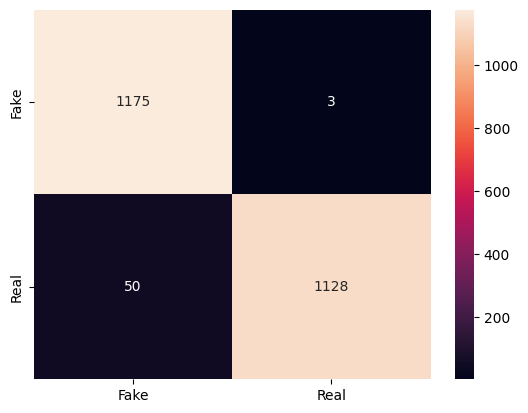

In [ ]:
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot= True, fmt='.4g')
ax.xaxis.set_ticklabels(['Fake', 'Real'])
ax.yaxis.set_ticklabels(['Fake', 'Real'])
plt.show()

## ROC-AUC 산출

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


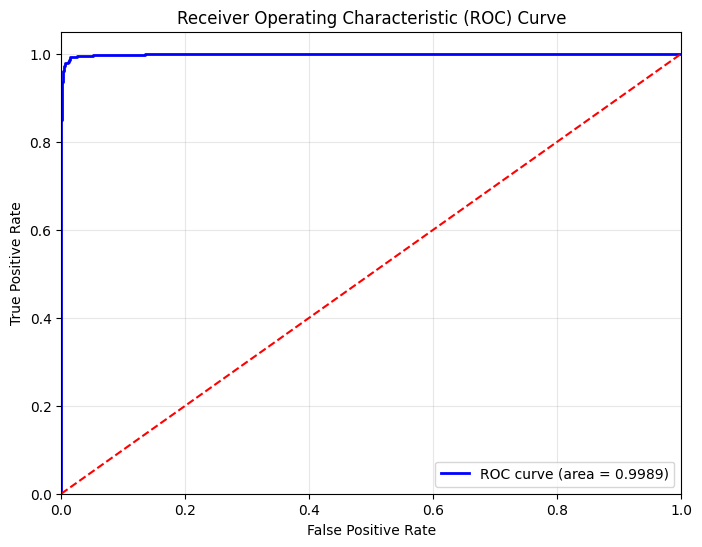

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 예측 확률값을 사용하여 ROC 곡선 생성
y_prob = model.predict(X_test).flatten()  # 예측 확률 값 (0 ~ 1 사이의 값)

# 실제 라벨과 예측 확률을 사용하여 FPR, TPR 값 계산
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# ROC-AUC 곡선 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # 대각선 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## Accuracy and Loss 곡선

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

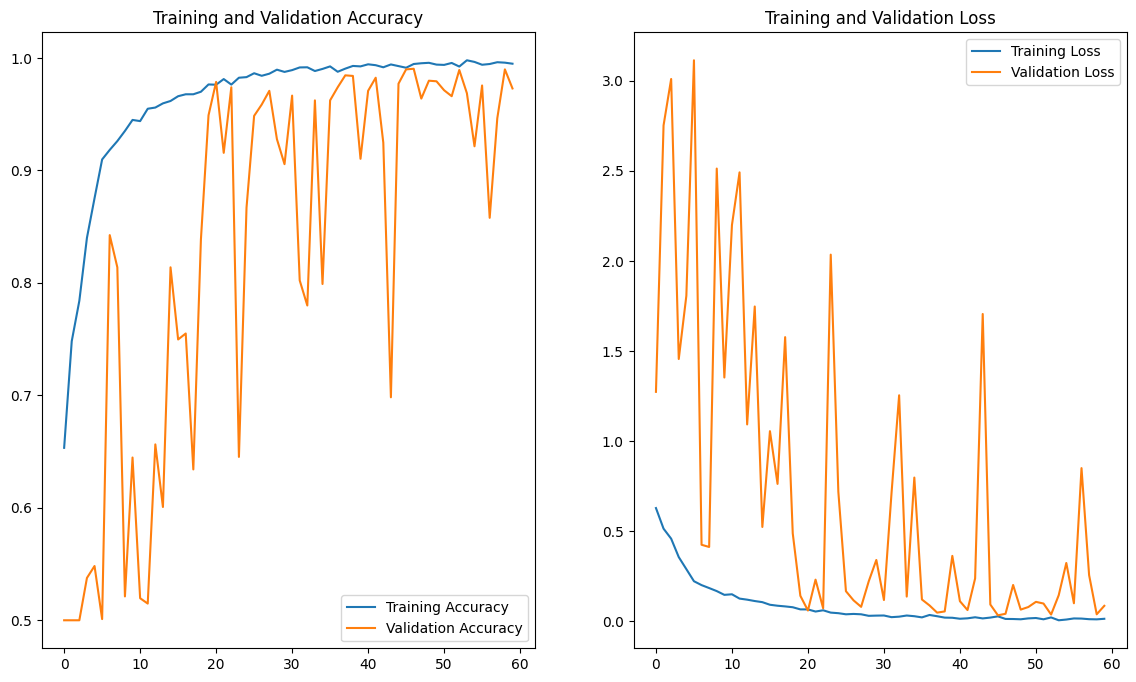

In [ ]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
EPOCHS = len(acc)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Smoothed Curve

In [ ]:
from scipy.ndimage import gaussian_filter1d

sacc = gaussian_filter1d(acc, sigma=2)
sval_acc = gaussian_filter1d(val_acc, sigma=2)

sloss = gaussian_filter1d(loss, sigma=2)
sval_loss = gaussian_filter1d(val_loss, sigma=2)

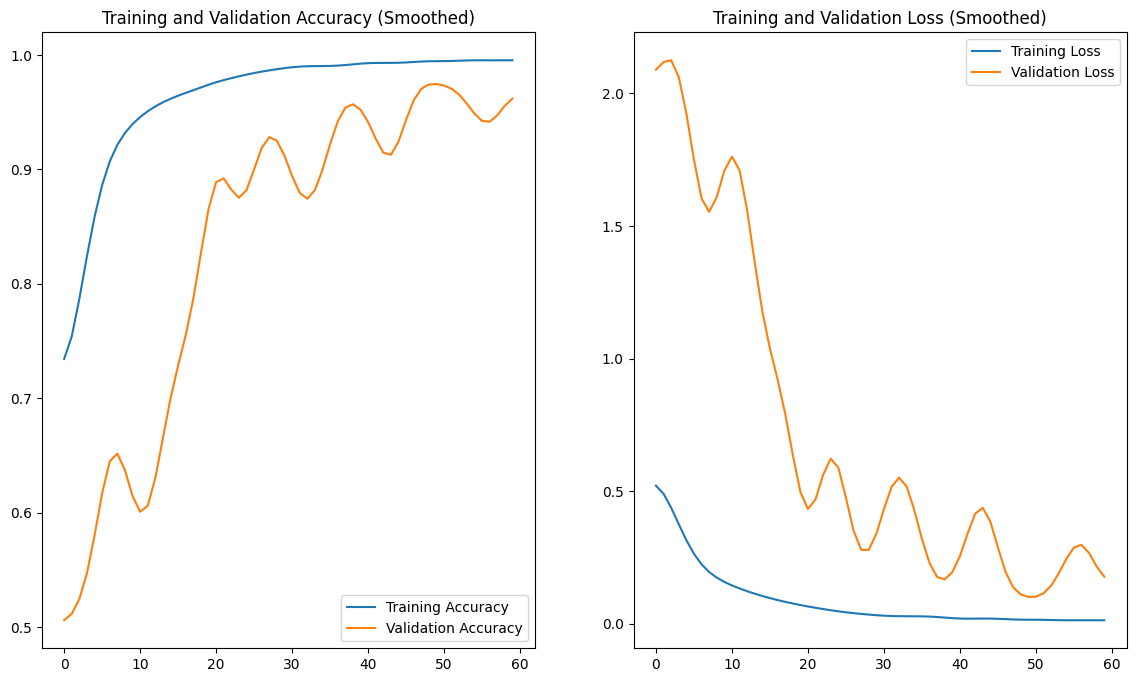

In [ ]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), sacc, label='Training Accuracy')
plt.plot(range(EPOCHS), sval_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Smoothed)')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), sloss, label='Training Loss')
plt.plot(range(EPOCHS), sval_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Smoothed)')
plt.show()

## 추가 데이터 테스트

In [ ]:
!cp /content/drive/MyDrive/hitpaw_test.csv /content/hitpaw_test.csv

124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Performance on Korean Test Dataset:
Accuracy: 0.5893854748603352
F1 Score: 0.7416520210896309
ROC-AUC Score: 0.5
Recall: 1.0
Precision: 0.5893854748603352




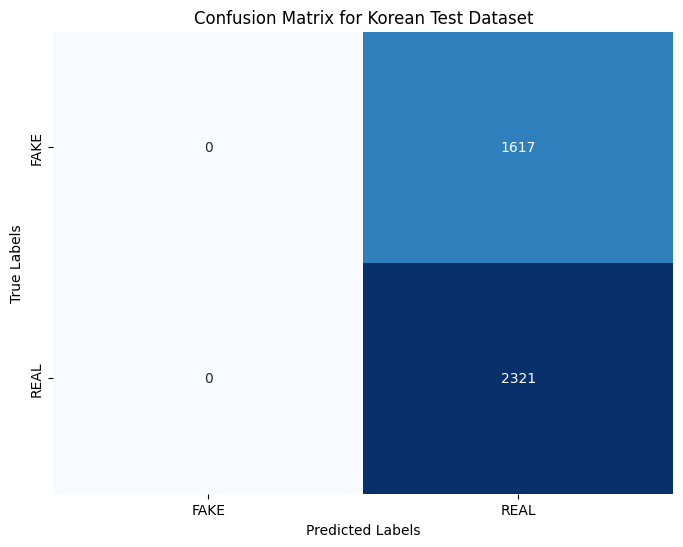

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# 파일 경로 설정
vocal_test_path = '/content/hitpaw_test.csv'
model_path = '/content/kaggle_norm_model.keras'

# 데이터 로드
vocal_test = pd.read_csv(vocal_test_path)

# 라벨 컬럼 분리
y_vocal_test = vocal_test['LABEL']
X_vocal_test = vocal_test.drop(columns=['LABEL'])

# 같은 LabelEncoder를 사용하여 라벨 인코딩
label_encoder = LabelEncoder()
label_encoder.fit(['REAL', 'FAKE'])  # 학습 데이터의 라벨 값으로 인코딩 학습
y_vocal_test_encoded = label_encoder.transform(y_vocal_test)

# 모델 로드
model = load_model(model_path)

# 데이터의 형태를 모델에 맞게 변환 (입력 데이터는 (샘플 수, 21, 5) 형식이어야 함)
def reshape_data(data, window_size=5):
    reshaped_data = []
    for i in range(len(data)):
        row = data.iloc[i].values
        reshaped_row = []
        for j in range(len(row) - window_size + 1):
            window = row[j: j + window_size]
            reshaped_row.append(window)
        reshaped_data.append(reshaped_row)
    return np.array(reshaped_data)

# 데이터 리셰이프
X_vocal_test_reshaped = reshape_data(X_vocal_test)

# 예측 수행
y_vocal_pred = np.round(model.predict(X_vocal_test_reshaped).flatten())

# 성능 지표 계산 함수
def evaluate_performance(y_true, y_pred, dataset_name):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"Performance on {dataset_name}:")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"ROC-AUC Score: {roc_auc}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print("\n")

    # Confusion matrix 시각화
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title(f'Confusion Matrix for {dataset_name}')
    ax.set_xticklabels(['FAKE', 'REAL'])
    ax.set_yticklabels(['FAKE', 'REAL'])
    plt.show()

# 성능 평가 및 confusion matrix 시각화
evaluate_performance(y_vocal_test_encoded, y_vocal_pred, "Korean Test Dataset")
